In [18]:
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

In [19]:
file_dir = os.getcwd()
data_dir = os.path.join(file_dir, 'datasets')

In [20]:
cds_csv_path = os.path.join(data_dir, 'cds.csv')
cds_data = pd.read_csv(cds_csv_path, index_col='Date')

In [21]:
cds_data.head()

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


In [22]:
def autocorrelation_plotter(dataset, ticker, lagmin=1, lagmax=50, squared=False):

    tickerset = dataset[dataset['Ticker'] == ticker]
    px_columns = [f'PX{i}' for i in range(1, 11)]

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
    axes = axes.flatten()

    # iterate over PX columns and plot ACF for each
    for i, col in enumerate(px_columns):
        price_col = tickerset[col]

        if squared == True:
            plot_acf(price_col**2, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')
        else:
            plot_acf(price_col, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')
        
        axes[i].set_xlim(lagmin, lagmax)
        axes[i].set_xlabel("Lags")
        axes[i].set_ylabel("Autocorrelation")
    
    plt.tight_layout()
    plt.suptitle(f"Autocorrelation of CDS Prices for Ticker: {ticker}", fontsize=14, y=1.02)
    plt.show()

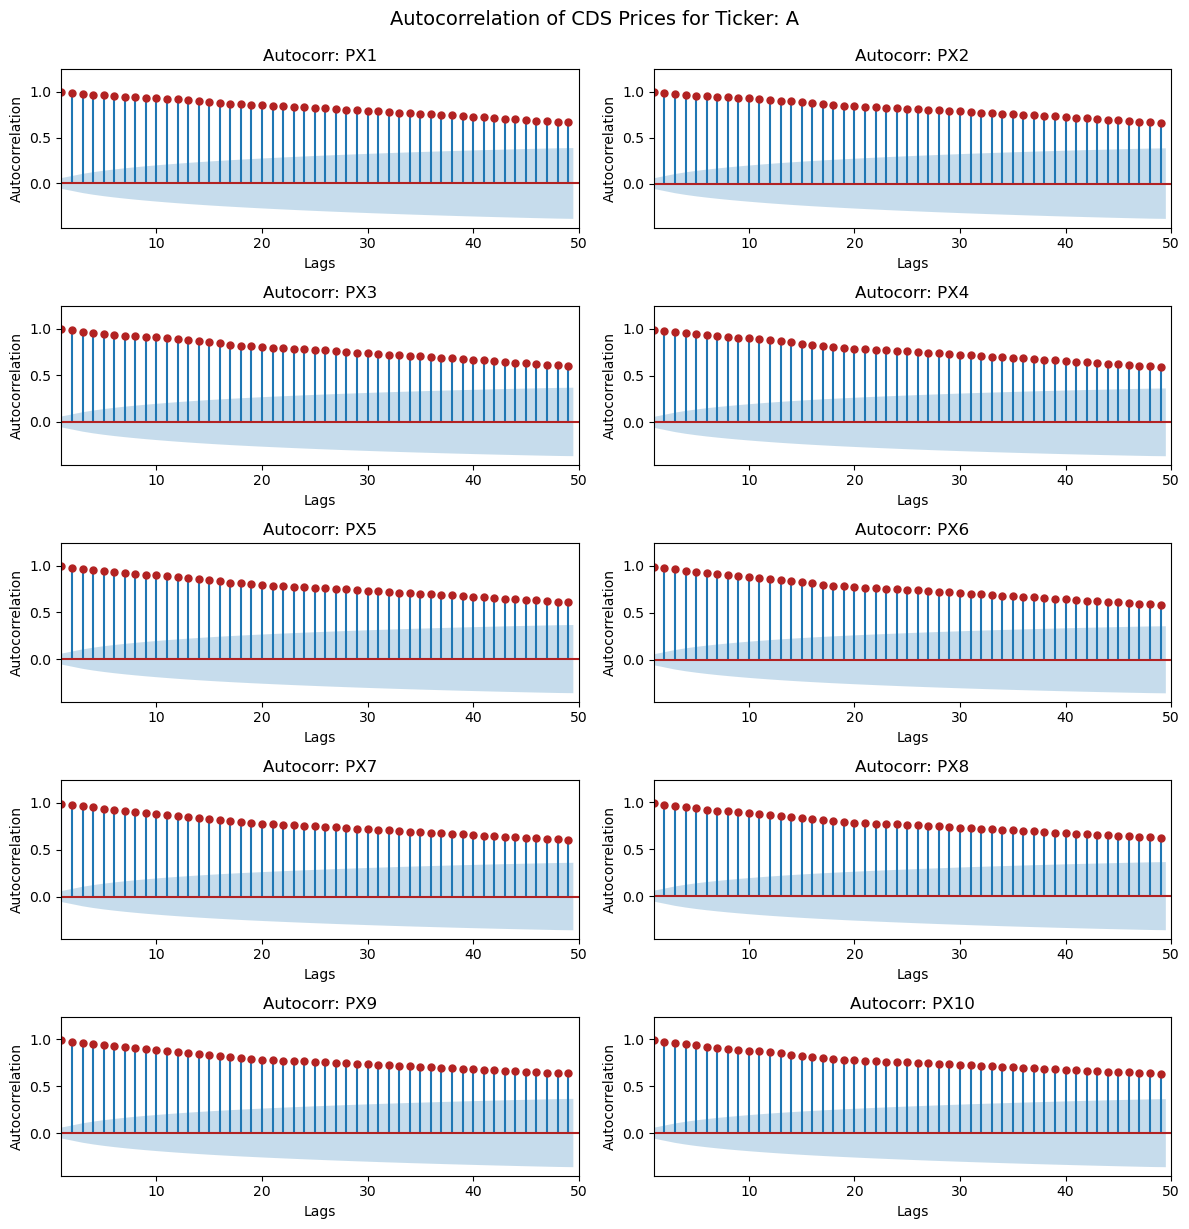

In [23]:
autocorrelation_plotter(cds_data, 'A')

In [24]:
def calculate_log_returns(dataset):
    
    px_columns = [f'PX{i}' for i in range(1, 11)]
    returns_df = dataset.copy()
    
    # group by ticker and apply log returns transformation
    for col in px_columns:
        returns_df[col] = dataset.groupby('Ticker')[col].transform(lambda price: np.log(price) - np.log(price.shift(1)))
    
    return returns_df

In [28]:
def calculate_first_diffs(dataset):
    
    px_columns = [f'PX{i}' for i in range(1, 11)]
    returns_df = dataset.copy()
    
    # group by ticker and apply log returns transformation
    for col in px_columns:
        returns_df[col] = dataset.groupby('Ticker')[col].transform(lambda price: price - price.shift(1))
    
    return returns_df

In [25]:
cds_returns = calculate_log_returns(cds_data)
cds_returns = cds_returns.dropna()

cds_returns.head()

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-02,A,Agilent Technologies Inc,0.000337,0.003984,0.002685,-0.001561,0.001158,0.001840,0.001548,0.000520,0.001103,0.001070
2015-01-05,A,Agilent Technologies Inc,-0.098986,-0.007583,0.003823,-0.047297,0.021299,0.004117,-0.008282,-0.008416,-0.008793,-0.009248
2015-01-06,A,Agilent Technologies Inc,0.143745,-0.003210,-0.000254,0.034718,0.031671,0.040604,0.045564,0.049068,0.051212,0.052885
2015-01-07,A,Agilent Technologies Inc,-0.020814,0.024614,0.024382,0.016376,0.015251,0.009983,0.007990,0.005174,0.003375,0.002328
2015-01-08,A,Agilent Technologies Inc,-0.030022,0.023257,0.008654,-0.003254,0.006251,-0.009898,-0.018898,-0.017621,-0.017295,-0.017279


In [29]:
cds_diffs = calculate_first_diffs(cds_data)
cds_diffs = cds_diffs.dropna()

cds_diffs.head()

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-02,A,Agilent Technologies Inc,0.005,0.10,0.105,-0.115,0.10,0.205,0.195,0.075,0.175,0.18
2015-01-05,A,Agilent Technologies Inc,-1.400,-0.19,0.150,-3.400,1.86,0.460,-1.040,-1.210,-1.390,-1.55
2015-01-06,A,Agilent Technologies Inc,2.080,-0.08,-0.010,2.480,2.84,4.640,5.830,7.200,8.270,9.06
2015-01-07,A,Agilent Technologies Inc,-0.320,0.62,0.970,1.200,1.40,1.170,1.050,0.780,0.560,0.41
2015-01-08,A,Agilent Technologies Inc,-0.450,0.60,0.350,-0.240,0.58,-1.160,-2.470,-2.640,-2.850,-3.02


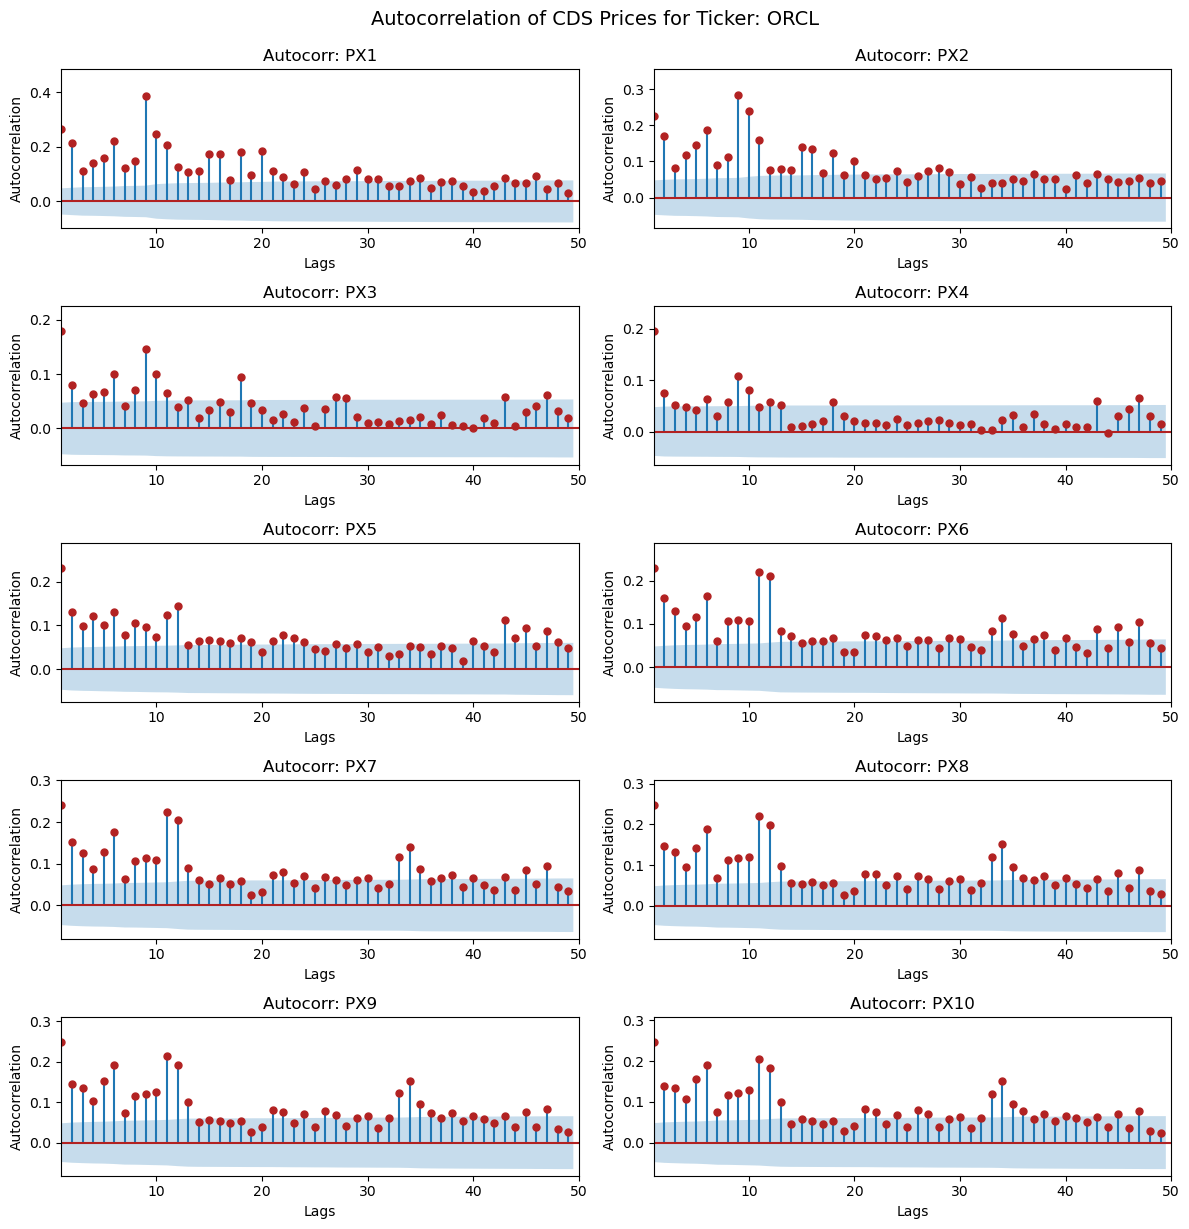

In [34]:
autocorrelation_plotter(cds_diffs, 'ORCL', squared=True)

We can see that a GARCH model is appropriate here